# Modelflow methods reference 

The main text of this document presents a large range of `modelflow` features in the context of where they may be used.  This chapter reproduces much of that information but out of context.  It is not a full technical reference to `modelflow` that can be found [here,]() but it does attempt to put into place a handy reference to many of the commands that a `modelflow` user of the World Bank models would need.


In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [2]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

In order to manipulate plots later on matplotlib.pyplot is also imported. 

In [3]:
import matplotlib.pyplot as plt # To manipulate plots 

## Useful Jupyter Notebook commands and features

### .widescreen() 

Instructs modelflow to take full advantage of the space available on the browser under which `Jupyter Notebook` is running.

In [4]:
model.widescreen() 

### .scroll_off()

Instructs modelflow not to scroll in lang cell but to show the whole output. Useful when displaying multiple charts and tables. 

In [5]:
model.scroll_off()

<IPython.core.display.Javascript object>

In [6]:
latex=1 

(modeldump-load)=
## Saving and loading a model from a file 

Models once built can be saved to disk for later reloading.  The entire model state can be saved, including options for the solve operator, and the results from solutions that were earlier run with the keep option.

The model state has many properties. Including: 

|content|object|
| --- | ---- | 
|Model equations|`.equation`|
|Model name  |`.modelname` |
|Model description |`.model_description` |
|Last solution|`.lastdf`   |
|Keept solutions|`.keep_solutions`   |
|Current time frame|`.current_per`   |
|Simulation options|`.oldkwargs`    |
|Variable descriptions|`.var_description   |
|Variable Groups|`.var_groups`    |
|Reports|`.reports`
 
 
Note that the `.lastdf` of the model which is dumped will become the `basedf` 
in the model instance of the model being loaded. 

### Method: `.modeldump`

The `.modeldump()` method saves the content of a model object to disk. By default models are stored using the [**json** format](https://en.wikipedia.org/wiki/JSON). By convention dumped modelflow objects are saved to a file with the **.pcim** extension.


 Parameters:

| Parameter | Type | Description |
|-----------|------|-------------|
| `outfile` | string | The name of the file where the model will be dumped. Default is an empty string, meaning the dump will be returned as a string. |
| `keep` | bool | If `True`, the `keep_solutions` attribute of the model will also be dumped. Default is `False`. |

 Returns

- **string**: If `outfile` is an empty string, the method returns the model dump as a JSON string.

#### example

`mpak.modeldump("models/Mymodel",keep=True)`

Saves the model object `mpak` to a file called Mymodel.pcim located in the models sub-directory.  The model would also contain the results dataframes for all the simulations that were stored with the keep option.


### Function: `modelload`

Instantiates (creates) a new model object from a previously saved pcim file. 

Parameters:

| Parameter | Type | Description |
|-----------|------|-------------|
| `infile` | string | The name of the file or URL from which the model will be loaded. |
| `funks` | list | Functions to use in the resulting model. Default is an empty list. |
| `run` | bool | If `True`, simulates the model with the saved time and options. Default is `False`. |
| `keep_json` | bool | If `True`, saves a dictionary (`self.json_keep`) in the model instance. Default is `False`. |
| `default_url` | string | The default URL where to look for the model if it is not in the specified location. Default value is: <br>'https://raw.githubusercontent.com/IbHansen/modelflow-manual/main/model_repo/',**kwargs):
        '''|
| `**kwargs` | dict | Additional keyword arguments used by the simulation if `run=True`. |

Returns

- **tuple**: A tuple containing a model instance and a DataFrame.



####  .modelload example 
Load a dumped model instance and create a new model instance. And solve the model.  

In [7]:
mpak,baseline = model.modelload('../models/pak.pcim',run=True)

file read:  ..\models\pak.pcim


Here the returned tuple is comprised of a model object, that is named mpak in this instance and a dataframe that is a copy of the `.lastdf` of the model object.  As the model was loaded with the run=True option. the `.lastdf` dataframe will contain the results of that most recent model solution.

(simulation)=
## Simulation/solving/calculation  
Modelflow has a number of different solvers which can be used for different types of models and in different circumstances. 

 1. `sim` Gauss-Seidel method for models with contemporaneous feedback 
 1. `newton` Newton-Raphson  method, alternative for models with contemporaneous feedback 
 1. `newton_stacked` Newton-Raphson  method for models with leaded variables 
 1. `xgenr` will calculate the result for models without contemporaneous feedback 
 1. `res` each equation is calculated on its own. Used to check the residuals.  


###  `.__call__` Solver wrapper 
The most convenient way to solve a model is to call it through a call to the model instance. Like this: 

>result =  mpak(\<dataframe>)

This is the simple call. The model will be solved for the years used in the last simulation and with the options used in the last simulation. 

Behind the scene this wrapper is implemented as the model class method `__call__`. This function manages the:
 - selection of solver function 
 - persistence of solve options, 
 - the `.basedf`, '.lastdf` feature
 - the `.keep_solution` feature. 

### Parameters for `__call__` Method



| Parameter           | Type           |  Description   |
|---------------------|----------------|----------------|
| `do_calc_add_factor`| bool           |  Determines whether to calculate the adjustment factor if the calc adjust model is present. Default is True. |
| `reset_options`     | bool           |  If True, the previous options will be reset. Default is False. |
| `solver`            | str            |  Specifies the solver to be used. Default is chosen based on the model's properties. |
| `silent`            | bool           |  If True, the solver runs silently without printing outputs to the console. Default is True. |
| `keep`              | str            |  If provided, keeps the solutions. Behavior depends on the `keep_variables` option. |
| `keep_variables`    | str, list of str| Specifies which variables to keep if the `keep` option is provided. Default is '*' - to keep all variables. |
| `*args`             | various        |  Variable length argument list. Usual the dataframe and start and end year  |
| `**kwargs`          | various        |  Arbitrary keyword arguments. These are provided to the actual solver |

 Returns

- `outdf`: pandas.DataFrame - The DataFrame containing the results of the model run.


#### Running a simulation

### Running a simulation with specific parameters
```python
results = mpak.sim(baseline, 2023, 2050, alfa=0.5, max_iterations=100)
```

### .sim, Gauss-Seidel solver
This solver is used by most world bank models.  


The `.sim` method solves a simultaneous model using the Gauss-Seidel method. 

Parameters:

| Parameter           | Type         | Description                                                                                          |
|---------------------|--------------|------------------------------------------------------------------------------------------------------|
| `databank`          | dataframe    | Input DataFrame containing the data to be used in the simulation.                                    |
| `start`             | TYPE         | The start of the simulation period. Defaults to ''.                                                  |
| `end`               | TYPE         | The end of the simulation period. Defaults to ''.                                                    |
| `silent`            | bool         | If set to False, displays simulation logs. Defaults to True.                                         |
| `samedata`          | bool         | If True, indicates the input data has the same structure as the last simulation. Defaults to False.  |
| `alfa`              | float        | The damping factor applied during simulation. Defaults to 1.0.                                       |
| `stats`             | bool         | If True, displays statistics after the simulation is complete. Defaults to False.                    |
| `first_test`        | int          | The iteration number to start testing for convergence. Defaults to 5.                                |
| `max_iterations`    | int          | The maximum number of iterations allowed for the simulation. Defaults to 200.                        |
| `conv`              | str          | Specifies the variables to test for convergence. Defaults to '*'.                                    |
| `absconv`           | float        | Sets the absolute convergence criterion level. Defaults to 0.01.                                     |
| `relconv`           | float        | Sets the relative convergence criterion level. Defaults to `DEFAULT_relconv`.                        |
| `transpile_reset`   | bool         | If True, ignores the previously transpiled model. Defaults to False.                                 |
| `dumpvar`           | str          | Specifies the variables for which to dump the iterations. Defaults to '*'.                           |
| `init`              | bool         | If True, takes the previous period’s value as the starting value. Defaults to False.                  |
| `ldumpvar`          | bool         | If True, dumps the iterations. Defaults to False.                                                    |
| `dumpwith`          | int          | Not described in the original docstring. Defaults to 15.                                             |
| `dumpdecimal`       | int          | Not described in the original docstring. Defaults to 5.                                              |
| `chunk`             | int          | Specifies the chunk size of the transpiled model. Defaults to 30.                                    |
| `ljit`              | bool         | If True, enables Just-In-Time compilation. Defaults to False.                                        |
| `stringjit`         | bool         | If True, uses Just-In-Time compilation on a string, not a file. Defaults to False.                    |
| `timeon`            | bool         | If True, times the elements of the simulation. Defaults to False.                                    |
| `fairopt`           | TYPE         | Options for Fair Taylor approximation. Defaults to `{'fair_max_iterations': 1}`.                    |
| `progressbar`       | TYPE         | If True, shows a progress bar during the simulation. Defaults to False.                              |
| `**kwargs`          | various      | Additional keyword arguments for more customized control over the simulation.                        |

Returns

- A DataFrame with the simulation results.

### Troubleshooting simulations
It is not certain that a model can be solved by Gauss-Seidle. However there are ways to increase the probability if the model don't converge to a solution. 

The Gauss-Seidel algorithm is quite straight forward. It basically iterates over the formulas, until convergence.

Let:
 - $z$ be all predetermined values: all exogenous variables and lagged endogenous variables.
 - $n$ be the number of endogenous variables.
 - $\alpha$ dampening factor which can be applied to selected equations.
 - $i$ endogenous variables
 - $k$ iterations

For each time period we can find a solution by doing Gauss-Seidel iterations:

>for $k = 1$ to convergence 
>>for $i$ = 1 to $n$
>>>$y_{i}^{k} = (1-\alpha) * y_{i}^{{k-1}} + \alpha f_i(y_1^{k},\cdots,y_{i-1}^{k},y_{i+1}^{k-1},\cdots,y_{n}^{k-1},z)$

#### Convergence: relconv,  absconv, conv
After each iteration the convergence is achieved if the relative change from the iteration before if below `relconv` for selected endogenous variables. As the relative change for small values can be very large only variables with values above `absconv`are checked. As default all endogenous variable are checked, however the user can select a subset of variables to check by setting the `conv`to the names for which to check. 

#### silent 
Set silent=False, in order to learn more about the number of iterations 

#### max_iterations 
Can be increased

#### alfa
This parameter determines the dampening of damp'able equations. The value should be between 1 and 0.1. 



### `.newton` and `stacked_newton`
Use the Newton-Raphson method for solving models. The stacked version solves the 
model for all years as one model. Used when solving models with leads. 

Parameters

| Parameter | Type | Description |
|-----------|------|-------------|
| `self` | object | The instance of the class where this method is defined. |
| `databank` | DataFrame | The databank on which the model will be evaluated. |
| `start` | string | The start period for the evaluation. Default is an empty string. |
| `end` | string | The end period for the evaluation. Default is an empty string. |
| `silent` | int | Determines whether to print progress messages. Default is 1 (silent). |
| `samedata` | int | Not used in the provided code. Default is 0. |
| `alfa` | float | A parameter used in the evaluation. Default is 1.0. |
| `stats` | bool | If True, prints statistics after the evaluation. Default is False. |
| `first_test` | int | The iteration at which to start testing for convergence. Default is 1. |
| `newton_absconv` | float | The absolute convergence criterion. Default is 0.001. |
| `max_iterations` | int | The maximum number of iterations for the Newton method. Default is 20. |
| `conv` | string | Specifies the variables to check for convergence. Default is '*'. |
| `absconv` | float | The absolute convergence level. Default is 1.0. |
| `relconv` | float | The relative convergence level. Default is DEFAULT_relconv. |
| `nonlin` | bool | If True, updates the solver in nonlinear iterations. Default is False. |
| `timeit` | bool | If True, times the execution of the method. Default is False. |
| `newton_reset` | int | Determines whether to reset the Newton method. Default is 1. |
| `dumpvar` | string | Specifies the variables to dump. Default is '*'. |
| `ldumpvar` | bool | If True, enables the dumping of variables. Default is False. |
| `dumpwith` | int | Not used in the provided code. Default is 15. |
| `dumpdecimal` | int | Not used in the provided code. Default is 5. |
| `chunk` | int | Determines the chunk size for JIT compilation. Default is 30. |
| `ljit` | bool | If True, enables JIT compilation. Default is False. |
| `stringjit` | bool | If True, enables JIT compilation for strings. Default is False. |
| `transpile_reset` | bool | If True, resets the transpiler. Default is False. |
| `init` | bool | If True, initializes the method. Default is False. |
| `newtonalfa` | float | A parameter for the Newton method. Default is 1.0. |
| `newtonnodamp` | int | The iteration at which to stop damping in the Newton method. Default is 0. |

returns a dataframe with the solution


### .oldkwargs, persistent simulation options 
The `oldkwargs` property of the model object is automatically set with each simulation storing the options that were active when it was executed.  Unless options are changed they are persistent between calls to a given model object. The `.oldkwargs` property of a model object  stores the  persistent parameters.

Currently, the persistent option values are:

In [8]:
mpak.oldkwargs

{'silent': 1, 'alfa': 0.7, 'ldumpvar': 0}

Persistent options may be reset (set to their defaults) by The user by setting the dictionary to the empty set. 
```
mpak.oldkwargs = {}
```

### .var_with_frmlname('DAMP'), Dampable variables
Equations in the Modelflow business language looks like this: 
> FRML \<options> \<right hand variable> = \<left hand side  expression>

The option: `DAMP` makes an equation dampable.

To retrieve all dampable variables. use 
> mpak.var_with_frmlname('DAMP')

It returns a **set** of variable names. Below the the set is made to a sorted **list** and the first 3 variable names are printed. 

In [9]:
dampable_variables = sorted(mpak.var_with_frmlname('DAMP'))
print(f'Number of dampable variables: {len(dampable_variables)}')
print(f'First 3 dampable variables  : {dampable_variables[:3]}')


Number of dampable variables: 75
First 3 dampable variables  : ['PAKBMFSTOTHRCD', 'PAKBMFSTREMTCD', 'PAKBMGSRGNFSCD']


Below the equation for the first of these variable is shown. The convention when creating 
World Bank model is to dampen all stochastic equations. 

In [10]:
mpak.PAKBXGSRMRCHCD.frml

Endogeneous: PAKBXGSRMRCHCD: Exp., MRCH (BOP), US$ mn
Formular: FRML <DAMP,STOC> PAKBXGSRMRCHCD = (PAKBXGSRMRCHCD(-1)*EXP(PAKBXGSRMRCHCD_A+ (2.82268702067837E-08*(LOG(PAKBXGSRMRCHCD(-1))-505277.224656802*LOG(PAKXMKT(-1))-2.91054176583784*LOG(PAKREER(-1)))+0.0683002735007435+0.167350489665585*((LOG(PAKXMKT))-(LOG(PAKXMKT(-1))))+0.0611655503957304*((LOG(PAKREER))-(LOG(PAKREER(-1))))) )) * (1-PAKBXGSRMRCHCD_D)+ PAKBXGSRMRCHCD_X*PAKBXGSRMRCHCD_D  $

PAKBXGSRMRCHCD  : Exp., MRCH (BOP), US$ mn
PAKBXGSRMRCHCD_A: Add factor:Exp., MRCH (BOP), US$ mn
PAKBXGSRMRCHCD_D: Fix dummy:Exp., MRCH (BOP), US$ mn
PAKBXGSRMRCHCD_X: Fix value:Exp., MRCH (BOP), US$ mn
PAKREER         : Real Exchange Rate (Trade Weighted)
PAKXMKT         : Weighted Trading Partner Demand




### Fixing variables values and calculation of add factors 
Stocastic equations can have their values fixed and can incorporate a add factor. Below it is shown for a variable named `C`

By setting `C_D` to 1 `C` will be calculated to the value `C_X`

The value of the add factor will be calculated after the model has been solved. Thus the **unfixing** of the variable don't move the solution. 

> FRML \<options> C = (expression + C_A) * (1 - C_D) + C_X * C_D 

#### `.fix()` Fixing  values 

The .fix() will set \<var>_D to 1 and \<var>_X to \<var> for all variables in matching the pattern. 

| Parameter | Type           | Description                                                   |
|-----------|----------------|---------------------------------------------------------------|
| `df`      | TYPE           | Input dataframe should contain a solution and all variables.  |
| `pat`     | TYPE, optional | Select variables to exogenize. Defaults to '*'.              |
| `start`   | TYPE, optional | Start period. Defaults to ''.                                 |
| `end`     | TYPE, optional | End period. Defaults to ''.                                   |
| `silent`  | int, optional  | If set to 1, suppresses print output. Defaults to 0.          |

####  `.unfix()` Unfixing values
The .unfix() will set \<var>_D to 0  
| Parameter | Type             | Description                                                   |
|-----------|------------------|---------------------------------------------------------------|
| `df`      | Dataframe        | Input dataframe, should contain a solution and all variables. |
| `pat`     | string, optional | Select variables to endogenize. Defaults to '*'.              |
| `start`   | TYPE, optional   | Start period. Defaults to ''.                                 |
| `end`     | TYPE, optional   | End period. Defaults to ''.                                   |


#### `.fix_inf()` Returns information regarding current fixing  

#### `.wb_behavioral`, return a list of fixable variables. 

## Modifying models
A new model instance with deleted, modified or added 
equations can be produced. 

### `.eqdelete` Delete equations 

| Parameter | Type           | Description                                                   |
|-----------|----------------|---------------------------------------------------------------|
| `deleteeq`| TYPE, optional | Variables where equations are to be deleted. Defaults to None.|
| `newname` | string, optional| The name of the new model with deleted equations. Defaults to an empty string.|

**Returns:**

- `newmodel`: TYPE - The new model with the deleted equations.
- `newdf`: TYPE - A dataframe with calculated add factors. Origin is the original model's lastdf.


### `.equpdate ` Update or add  equations 

| Parameter      | Type           | Description                                                   |
|----------------|----------------|---------------------------------------------------------------|
| `updateeq`     | TYPE           | New equations separated by newline.                           |
| `add_add_factor`| bool, optional| Whether to add an add factor. Defaults to False.              |
| `calc_add`     | bool, optional | Whether to calculate add factors. Defaults to True.           |
| `do_preprocess`| bool, optional | Whether to preprocess the equations. Defaults to True.        |
| `newname`      | string, optional| The name of the updated model. Defaults to an empty string.   |
| `silent`       | bool, optional | Whether to suppress print outputs. Defaults to True.          |

**Returns:**

- `newmodel`: TYPE - The updated model with new and deleted equations.
- `newdf`: TYPE - A dataframe with calculated add factors. Origin is the original model's lastdf.


## Dataframe extensions for updating and transformation. 
Pandas dataframes can be extended with new functionality. When the `import modelclass` statement is executed modelflow will 
extend dataframes with two new capabilities. 
 - **.upd** which allows easy updating of variables (columns) in dataframes. The purpose is to facilitate relevant update operations. 
 - **.mfcalc** which enables transformations using lags and straight expressions. 
 
 

### `.upd` [Updates](upd) a dataframe and returns a dataframe

Parameters:

| Parameter    | Type    | Description   | Default |
|--------------|---------|---------------|---------|
| `basis`      | string  | Lines with variable updates (see below for format). | |
| `lprint`     | bool, optional | If `True`, each update is printed. | `False` |
| `scale`      | float, optional | A multiplier used on all update input. | `1.0` |
| `create`     | bool, optional | Creates variables if not in the dataframe. | `True` |
| `keep_growth`| bool, optional | Keep the growth rate after the update time frame. | `False` |

A line in updates looks like this:

```plaintext
[<[[start] end]>] <var> <=|+|*|%|=growth|+growth|=diff> <value>... [--keep_growth_rate|--kg|--no_keep_growth_rate|--nkg]
```
The number of values should either be one - which then is applied to all years, or the number of years from start to end. 

Time carries over from line to line. 

The `basis`string can contain several updates separated by new line. 

Returns:
A new dataframe containing the updated values of the input dataframe 



### `.mfcalc` Updates a dataframe and returns a dataframe
This implement the model class on top of pandas dataframes. Useful to do transformations with lags. 


| Parameter | Type     | Description                                                                 | Default |
|-----------|----------|-----------------------------------------------------------------------------|---------|
| `eq`      | str     | Equations, one on each line. Can be started with `<start end>` to control calculation sample. |         |
| `start`   | optional | DESCRIPTION.                                                               | `''`    |
| `end`     | optional | DESCRIPTION.                                                               | `''`    |
| `showeq`  | bool, optional | If `True`, the equations will be printed.                                  | `False` |
| `**kwargs`| optional     | Here all solve options can be provided.      |

Each equation $f_i$  is specified as:


```
<left hand side> = <right hand side> $
```

Each formula ends with a \$.

The ```<left hand side>``` should not contain transformations. Lags or leads can not be specified at the left hand side of $=$. 


Time $t$ is implicit in the equations which means that a $var$ at time $t$ written as ```var```, while $var_{t-1}$ is written as ```var(-1)```. ModelFlow is case-insensitive. Everything is eventually transformed into upper case.

The ```<right hand side>``` can contain variables, operators, functions 

(Saving-results)=
## Saving results for comparison  
When comparing results the user can take the result dataframe from two (or more)  simulation and use python do the necessary calculations and visualizations. However Modelflow provides some properties and methods which 
facilitates comparing more "out of the box". 

A model instance (in this case  `mpak` two "systems" to do this. The 
 1. **.basedf and .lastdf** dataframes. Which contains the first and the last solution of the model
 2. **.keep_solution** dictionary of dataframes. This is typical used when comparing several scenarios. 
 
### .basedf and .lastdf
In the example above there two dataframes with results ```baseline``` and ```scenario```. These dataframes can be manipulated and visualized
with the tools provided by the **pandas** library and other like **Matplotlib** and **Plotly**. However to make things easy the first and
latest simulation result is also in the mpak object:

- **mpak.basedf**: Dataframe with the values for baseline
- **mpak.lastdf**: Dataframe with the values for alternative  

This means that .basedf and .lastdf will contain the same result after the first simulation. <br>
If new scenarios are simulated the data in .lastdf will then be replaced with the latest results.

These dataframes are used by a number of model instance methods as you will see later.  

The user can assign dataframes to both .basedf and .lastdf. This is useful for comparing simulations which are not the first and last. 

### keep=\<Description>, create a  dictionary of dataframes from scenarios
Sometimes we want to be able to compare more than two scenarios. Using ```keep='some description'``` the dataframe with results can be saved into a dictionary with the description as key and the dataframe as value.  

mpak(<dataframe>,,keep=\<description>,,) 

The name of the dictionary will be mpak.keep_solutions

#### .keep_variables= \<selection string of variables>, Select variables to keep 
A modelinstance with many variables and/or many scenarios to keep can become very large. Therefor it can be useful not to keep all variables but to select a the variables which are needed. 

#### .keep_solutions = {}, resetting the .keep_solution 
Sometime it can be useful to reset the ```.keep_solutions```, so that a new set of solutions can be inspected. This is done by replacing it with an empty dictionary.

### Example 

In [11]:
mpak.keep_description = {}

_ = mpak(baseline,2020,2100,keep='Baseline') 

scenario_20  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 20")
_ = mpak(scenario_20,2020,2100,keep='Coal, Oil and Gastax : 20') # runs the simulation

scenario_40  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 40")
_ = mpak(scenario_40,2020,2100,keep='Coal, Oil and Gastax : 40') # runs the simulation

####  .keepswitch(), select scenarios for plotting
When creating many scenarios with the ```keep``` keyword it can sometime be useful to: 
- Plot selected scenarios and to change the sequence of the scenarios. 
- To use the .basedf and .lastdf as scenarios. 

To facilitate this the .keepswitch function has been created.

| Parameter |Explanation
| :- | :---|
|base_last = True\|False(default) |If True use the .basedf and .lastdf 
|scenario='\<string>'|Listing of scenarios separated by `\|` if no wildcards else space  
    
.keepswitch is a [context manager](https://www.pythontutorial.net/advanced-python/python-context-managers) like .set_smpl.
So it works in the scope of a ```with```. After the with statement the keept solutions are restored.

```
with mpak.keepswitch(scenarios = '\<selection>'):
   mpak.keep_plot('\<variable selection>',,)
```

#### .keep_plot(), plot the scenarios
This is a very agile function which can produce visualization of the keep't solutions


#### Parameters

| Parameter       | Type            | Description                                                                                      |
|-----------------|-----------------|--------------------------------------------------------------------------------------------------|
| `pat`           | string          | Pattern for variable selection. Defaults to '*'.                                                  |
| `start`         | TYPE            | Start period for the plot. Defaults to ''.                                                        |
| `end`           | TYPE            | End period for the plot. Defaults to ''.                                                          |
| `start_ofset`   | int             | Relative offset for the start period from the current period. Defaults to 0.                      |
| `end_ofset`     | int             | Relative offset for the end period from the current period. Defaults to 0.                        |
| `showtype`      | str             | Type of data transformation ('level', 'growth', or 'change'). Defaults to 'level'.                |
| `diff`          | bool            | If True, shows the difference to the first experiment. Defaults to False.                         |
| `diffpct`       | bool            | If True, shows the difference in percent to the first experiment. Defaults to False.              |
| `mul`           | float           | Multiplier for the data. Defaults to 1.0.                                                         |
| `title`         | str            | Title for the plot. Defaults to 'Show variables'.                                                 |
| `legend`        | bool            | If False, explanations are displayed to the right of the curve. Defaults to True.                 |
| `scale`         | str            | Scale of the plot ('log' or 'linear'). Defaults to 'linear'.                                      |
| `yunit`         | str            | Units for the y-axis. Defaults to ''.                                                             |
| `ylabel`        | str            | Label for the y-axis. Defaults to ''.                                                             |
| `dec`           | TYPE            | Number of decimals to display, automated if ''. Defaults to ''.                                   |
| `trans`         | dict            | Translation dictionary for variable names. Defaults to {}.                                        |
| `showfig`       | bool            | If False, the figure is not displayed. Defaults to True.                                          |
| `vline`         | list of tuples  | List of (time, text) for vertical lines on the plot. To erase, delete `model.vline`.              |
| `savefig`       | string          | Folder to save figures in, creates the folder if needed.                                          |
| `keep_dim`      | bool            | If True, each line represents a scenario; if False, each line represents a variable. Defaults to True. |
| `dataonly`      | bool            | If True, only the resulting data frames are returned, no plot is shown. Defaults to False.        |

 Returns

- `figs`: dict - Dictionary of the generated Matplotlib figures.

 Example Usage

```python
# Customize the plot for specific variables, periods, and additional settings
model.keep_plot(pat='GDP*', start='2020Q1', end='2030Q4', scale='log', savefig='plots/')


(time-frame)=
## .current_per, The time frame
Most operations on a model class instance operates on the current time frame. 
It is a subset of the row index of the dataframe which is simulated. 


In this case it is: 

In [12]:
mpak.current_per

Int64Index([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
            2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
            2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
            2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
            2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
            2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
            2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
            2097, 2098, 2099, 2100],
           dtype='int64')

The possible times in the dataframe is contained in the ```<dataframe>.index``` property. 

In [13]:
baseline.index  # the index of the dataframe

Int64Index([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', length=121)

### .smpl, Set time frame 
The time frame can be set like this:

In [14]:
mpak.smpl(2020,2025)
mpak.current_per

Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')

### .set_smpl, Set timeframe for a local scope
For many operations it can be useful to apply the operations for a shorter time frame, but retain the global time frame after the operation. <br>
This can be done  with a ```with``` statement like this. 

In [15]:
print(f'Global time  before   {mpak.current_per}')
with mpak.set_smpl(2022,2023):
    print(f'Local time frame      {mpak.current_per}')
print(f'Unchanged global time {mpak.current_per}')

Global time  before   Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')
Local time frame      Int64Index([2022, 2023], dtype='int64')
Unchanged global time Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')


### .set_smpl_relative Set relative timeframe for a local scope
When creating a script it can be useful to set the time frame relative to the 
current time. 

Like this:

In [16]:
print(f'Global time  before   {mpak.current_per}')
with mpak.set_smpl_relative (-1,0):
    print(f'Local time frame      {mpak.current_per}')
print(f'Unchanged global time {mpak.current_per}')

Global time  before   Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')
Local time frame      Int64Index([2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')
Unchanged global time Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')


(index-operator)=

:::{index} single: ModelFlow Index operator; .[]
:::


## Using the index operator .[ ] to select and visualize variables. 

Using the index operator on the model instance like this: 
>mpak[\<variable selection>]

will return a special class (called ```.vis```). It implements a number 
of methods and properties which comes in handy for quick variable:
 - vizualization
 - analysis
 - information     

First the user has to select the relevant variables then several properties and methods can be chained



(variable-selection)=
### Variable selection
In several contexts it is possible to select a number of variables. Variables can be selected on different basis: 
 1. Variable name with wildcards 
 2. Variable descriptions with wildcarts 
 3. Variable groups
 4. all endogenous variables

#### '\<variable name with wildcards>'...  , select matching variables

To select variables the method accept patterns which defines variable names. Wildcards: 
- ```*``` matches everything
- ```?``` matches any single character
- ```\[seq]``` matches any character in seq
- ```\[!seq]``` matches any character not in seq



For more how wildcards can be used, the specification can be found [here](https://docs.python.org/3/library/fnmatch.html)


#### '\<#Variable group>' , select variables matching in variable group 

#### .var_groups, a dictionary of variable groups 
The property `.var_groups` can contain a dictionary of variables defined by variable names with wildcards. 

In [17]:
mpak.var_groups


{'Headline': '???GDPpckn ???NRTOTLCN ???LMEMPTOTL ???BFFINCABDCD  ???BFBOPTOTLCD ???GGBALEXGRCN ???BNCABLOCLCD_ ???FPCPITOTLXN',
 'National income accounts': '???NY*',
 'National expenditure accounts': '???NE*',
 'Value added accounts': '???NV*',
 'Balance of payments exports': '???BX*',
 'Balance of payments exports and value added ': '???BX* ???NV*',
 'Balance of Payments Financial Account': '???BF*',
 'General government fiscal accounts': '???GG*',
 'World all': 'WLD*',
 'PAK all': 'PAK*'}

#### Example

In [18]:
mpak['#Balance of payments exports'].des

PAKBXFSTCABTCD        : Exp., Factor Services and Transfers (BOP), US$ mn
PAKBXFSTOTHRCD        : Exp., Other Factor Services and Transfers (BOP), US$ mn
PAKBXFSTOTHRCD_A      : Add factor:Exp., Other Factor Services and Transfers (BOP), US$ mn
PAKBXFSTOTHRCD_D      : Fix dummy:Exp., Other Factor Services and Transfers (BOP), US$ mn
PAKBXFSTOTHRCD_FITTED : Fitted  value:Exp., Other Factor Services and Transfers (BOP), US$ mn
PAKBXFSTOTHRCD_X      : Fix value:Exp., Other Factor Services and Transfers (BOP), US$ mn
PAKBXFSTREMTCD        : Exp., Remittances (BOP), US$ mn
PAKBXFSTREMTCD_A      : Add factor:Exp., Remittances (BOP), US$ mn
PAKBXFSTREMTCD_D      : Fix dummy:Exp., Remittances (BOP), US$ mn
PAKBXFSTREMTCD_FITTED : Fitted  value:Exp., Remittances (BOP), US$ mn
PAKBXFSTREMTCD_X      : Fix value:Exp., Remittances (BOP), US$ mn
PAKBXGSRGNFSCD        : Exp., GNFS (BOP), US$ mn
PAKBXGSRGNFSCD_A      : Add factor:Exp., GNFS (BOP), US$ mn
PAKBXGSRGNFSCD_D      : Fix dummy:Exp., GNFS (B


#### '\<!search pattern>' , select variables where search pattern with  wildcards is matching description  

#### .var_descriptions, a dictionary of variable descriptions 
The property `.var_description` contains a dictionary with variable names as key and a description as value. 

#### Example

In [19]:
mpak['!*import*'].des

PAKBMFSTINTECD        : Imports, External Debt Interest Payments
PAKNEIMPGNFSKN        : Imports real
PAKNEIMPGNFSKN_A      : Add factor:Imports real
PAKNEIMPGNFSKN_D      : Fix dummy:Imports real
PAKNEIMPGNFSKN_FITTED : Fitted  value:Imports real
PAKNEIMPGNFSKN_X      : Fix value:Imports real
PAKNVCOLNIMPQN        : Coal, net import (ktoe)
PAKNVGASNIMPQN        : Gas, net import (ktoe)
PAKNVOILNIMPQN        : Oil, net import (ktoe)
PAKNVRENNIMPQN        : "Renewables", net import (ktoe)
PAKPMKEY              : Keyfitz Price Imports


#### '#ENDO' , select all edogenous variables  

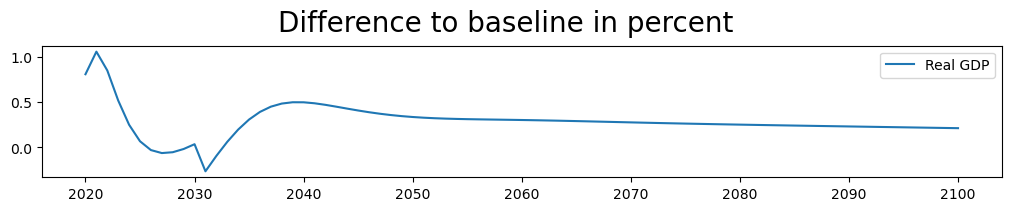

In [20]:
with mpak.set_smpl(2020,2100):
    mpak['PAKNYGDPMKTPKN'].difpctlevel.mul100.rename().plot(colrow=1,
                title='Difference to baseline in percent');

### Access values in .lastdf and .basedf

To limit the output printed, we set the time frame to 2020 to 2023. 

In [21]:
mpak.smpl(2020,2023);

:::{index} single: .[]; Display information widget 
:::


To access the values of 'PAKNYGDPMKTPKN' and 'PAKNECONPRVTKN' from the latest simulation a small widget is displayed. 

In [22]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'] 

:::{index} single: .[]; .base Access basedf 
:::

To access the values of 'PAKNYGDPMKTPKN' and 'PAKNECONPRVTKN' from the base dataframe, specify .base

In [23]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].base.df


,PAKNYGDPMKTPKN,PAKNECONPRVTKN
2020,2.627394e+07,2.367289e+07
2021,2.651137e+07,2.397282e+07
2022,2.668514e+07,2.416413e+07
2023,2.696308e+07,2.442786e+07


:::{index} single: .[]; .df Return a dataframe 
:::


### .df  Pandas dataframe 

Sometime you need to perform additional operations on the values. Therefor the .df will return a dataframe with the selected variables. 


In [24]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].df

,PAKNYGDPMKTPKN,PAKNECONPRVTKN
2020,2.648605e+07,2.338267e+07
2021,2.679140e+07,2.358771e+07
2022,2.691168e+07,2.368379e+07
2023,2.710269e+07,2.385588e+07



### .show  as a html table with tooltips 

If you want the variable descriptions use this 


In [25]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].show

:::{index} single: .[]; .names Variable names
:::

### .names Variable names

If you select variables using wildcards, then you can access the names that correspond to your query.



In [26]:
mpak['PAKNYGDP??????'].names

['PAKNYGDPDISCCN',
 'PAKNYGDPDISCKN',
 'PAKNYGDPFCSTCN',
 'PAKNYGDPFCSTKN',
 'PAKNYGDPFCSTXN',
 'PAKNYGDPMKTPCD',
 'PAKNYGDPMKTPCN',
 'PAKNYGDPMKTPKD',
 'PAKNYGDPMKTPKN',
 'PAKNYGDPMKTPXN',
 'PAKNYGDPPOTLKN']

:::{index} single: .[]; .frml show normalized equation(s)
:::



### .frml The formulas 

Use .frml to access all the equations for the endogenous variables.  

In [27]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].frml

PAKNYGDPMKTPKN : FRML <IDENT> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $
PAKNECONPRVTKN : FRML <DAMP,STOC> PAKNECONPRVTKN = (PAKNECONPRVTKN(-1)*EXP(PAKNECONPRVTKN_A+ (-0.2*(LOG(PAKNECONPRVTKN(-1))-LOG(1.21203101101442)-LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1)))+0.763938860758873*((LOG((((PAKBXFSTREMTCD-PAKBMFSTREMTCD)*PAKPANUSATLS)+PAKGGEXPTRNSCN+PAKNYYWBTOTLCN*(1-PAKGGREVDRCTXN/100))/PAKNECONPRVTXN))-(LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1))))-0.0634474791568939*DURING_2009-0.3*(PAKFMLBLPOLYXN/100-((LOG(PAKNECONPRVTXN))-(LOG(PAKNECONPRVTXN(-1)))))) )) * (1-PAKNECONPRVTKN_D)+ PAKNECONPRVTKN_X*PAKNECONPRVTKN_D $


:::{index} single: .[]; .eviews displays the EViews equations - if avaiable
:::

### .eviews The formulas 

Use .eviews to access all the equations for the endogenous variables.  

In [29]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].eviews

PAKNYGDPMKTPKN : 
@IDENTITY PAKNYGDPMKTPKN  = PAKNECONPRVTKN  + PAKNECONGOVTKN  + PAKNEGDIFTOTKN  + PAKNEGDISTKBKN  + PAKNEEXPGNFSKN  - PAKNEIMPGNFSKN  + PAKNYGDPDISCKN  + PAKadap  * PAKDISPREPKN
  
PAKNECONPRVTKN : 
DLOG(PAKNECONPRVTKN) =- 0.2*(LOG(PAKNECONPRVTKN( - 1)) - LOG(1.21203101101442) - LOG((((PAKBXFSTREMTCD( - 1) - PAKBMFSTREMTCD( - 1))*PAKPANUSATLS( - 1)) + PAKGGEXPTRNSCN( - 1) + PAKNYYWBTOTLCN( - 1)*(1 - PAKGGREVDRCTXN( - 1)/100))/PAKNECONPRVTXN( - 1))) + 0.763938860758873*DLOG((((PAKBXFSTREMTCD - PAKBMFSTREMTCD)*PAKPANUSATLS) + PAKGGEXPTRNSCN + PAKNYYWBTOTLCN*(1 - PAKGGREVDRCTXN/100))/PAKNECONPRVTXN) - 0.0634474791568939*@DURING("2009") - 0.3*(PAKFMLBLPOLYXN/100 - DLOG(PAKNECONPRVTXN))


:::{index} single: .[]; .rename() Rename variables to description 
:::



### .rename() replaces the variable mnemonic with its description

Use .rename() to display results using the variable description instead of the mnemonic, which is the default behaviour. 



In [30]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].rename().df

,Real GDP,HH. Cons Real
2020,2.648605e+07,2.338267e+07
2021,2.679140e+07,2.358771e+07
2022,2.691168e+07,2.368379e+07
2023,2.710269e+07,2.385588e+07


:::{index} single: ModelFlow Dataframe Modifiers; Transformations 
:::

:::{index} single: ModelFlow Dataframe Modifiers; .pct  Growth rates
:::

:::{index} single: ModelFlow Dataframe Modifiers; .dif - difference in level
:::

:::{index} single: ModelFlow Dataframe Modifiers; .difpct - difference in growth rate
:::

:::{index} single: ModelFlow Dataframe Modifiers; .difpctlevel - difference in level as a pct of baseline
:::

:::{index} single: single: ModelFlow Dataframe Modifiers; .mul100 - multiply by 100
:::



### Transformations of solution results 

When the variables has been selected through the index operator a number of standard data transformations can be performed. 

|Transfomation|Meaning|expression 
|:--- |:--- |:--|
| growth (pct) | Growth rates | $\frac{this_t}{this_{t-1}} -1$ |
| dif |Difference in level | $l-b$ |
| difgrowth (difpct) | Difference in growth rate | ${\big[{\frac{l_t}{l_{t-1}}-1}\big]-\big[{\frac{b_t}{b_{t-1}}-1}\big]}$|
| difpctlevel |difference in level as a pct of baseline | $\frac{l_t-b_t}{b_t} $ |
| mul100 | multiply by 100 | ${this_t \times 100}$ |

- $this$ is the chained value. Default lastdf but if preceeded by .base the values from .basedf will be used 
- $b$ is the values from .basedf
- $l$ is the values from .lastdf 


### .dif Difference in level 

The 'dif' command displays the difference in levels of the latest and previous solutions.

$l-b$

where l is the variable from the .lastdf and b is the variable from .basedf.  

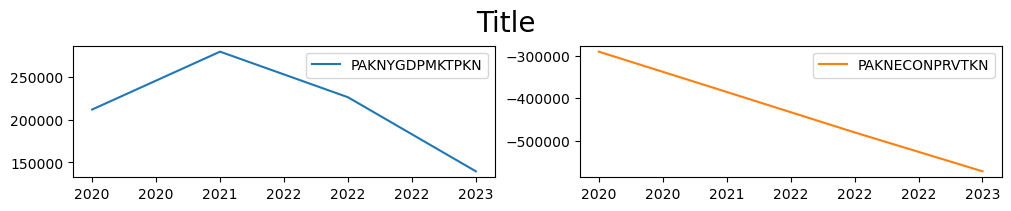

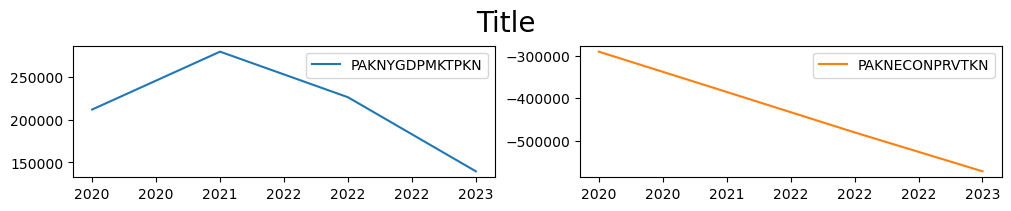

In [31]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dif.plot()

### .growth (.pct)  Growth rates 
Display growth rates

$\left(\cfrac{l_t}{l_{t-1}}-1\right )$

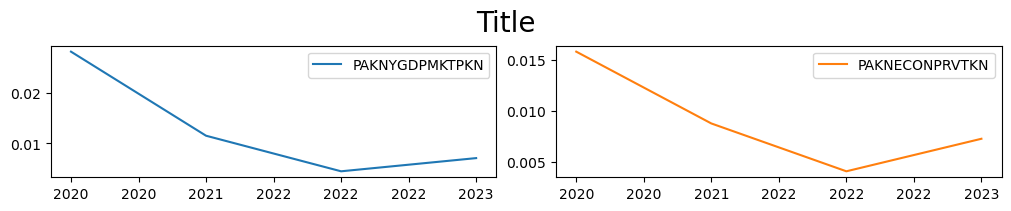

In [32]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].growth.plot();

### .difpct property difference in growth rates 
The difference in the growth rates  between the last and base dataframe.  

$\left( \cfrac{l_t}{l_{t-1}}-1 \right) - \left(\cfrac{b_t}{b_{t-1}}-1 \right)$

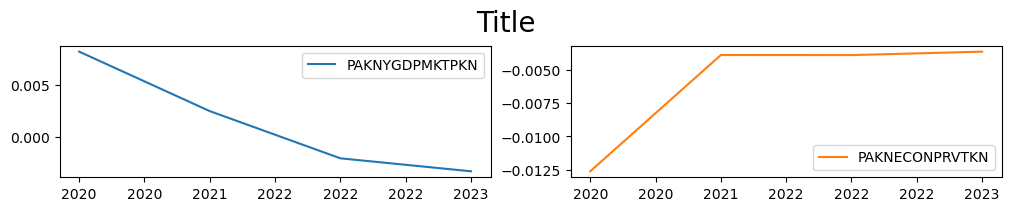

In [33]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.plot() ; 

### .difpctlevel percent difference of  levels 

$\left( \cfrac{l_t-b_t}{b_{t}} \right) $

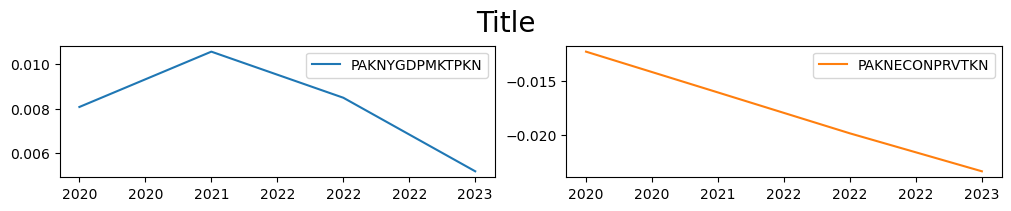

In [34]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpctlevel.plot();  

### .yoy_ar  Growth over 4 periods 
This should only be used for quarterly data 

$\left( \cfrac{l_t-b_{t-4}}{b_{t-4}} \right)-1 $

### .qoq_ar Annualized quarterly growth rate
Also for quarterly data 


$\left( \cfrac{l_t-b_t}{b_{t}} \right)^4-1 $

### mul100 multiply by 100 

multiply growth rate by 100. 

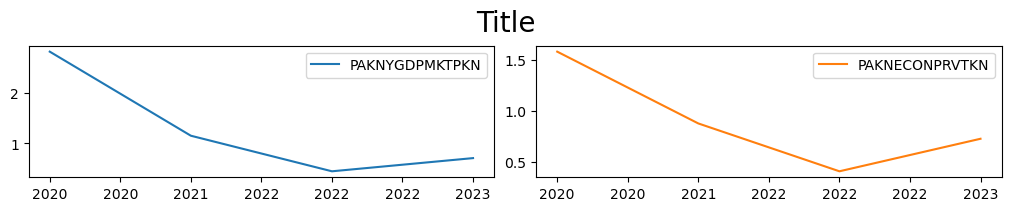

In [35]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.mul100.plot() ;


## .plot chart the selected and transformed variables
After the variables has been selected and transformed, they can  be plotted. The .plot() method plots the selected variables separately

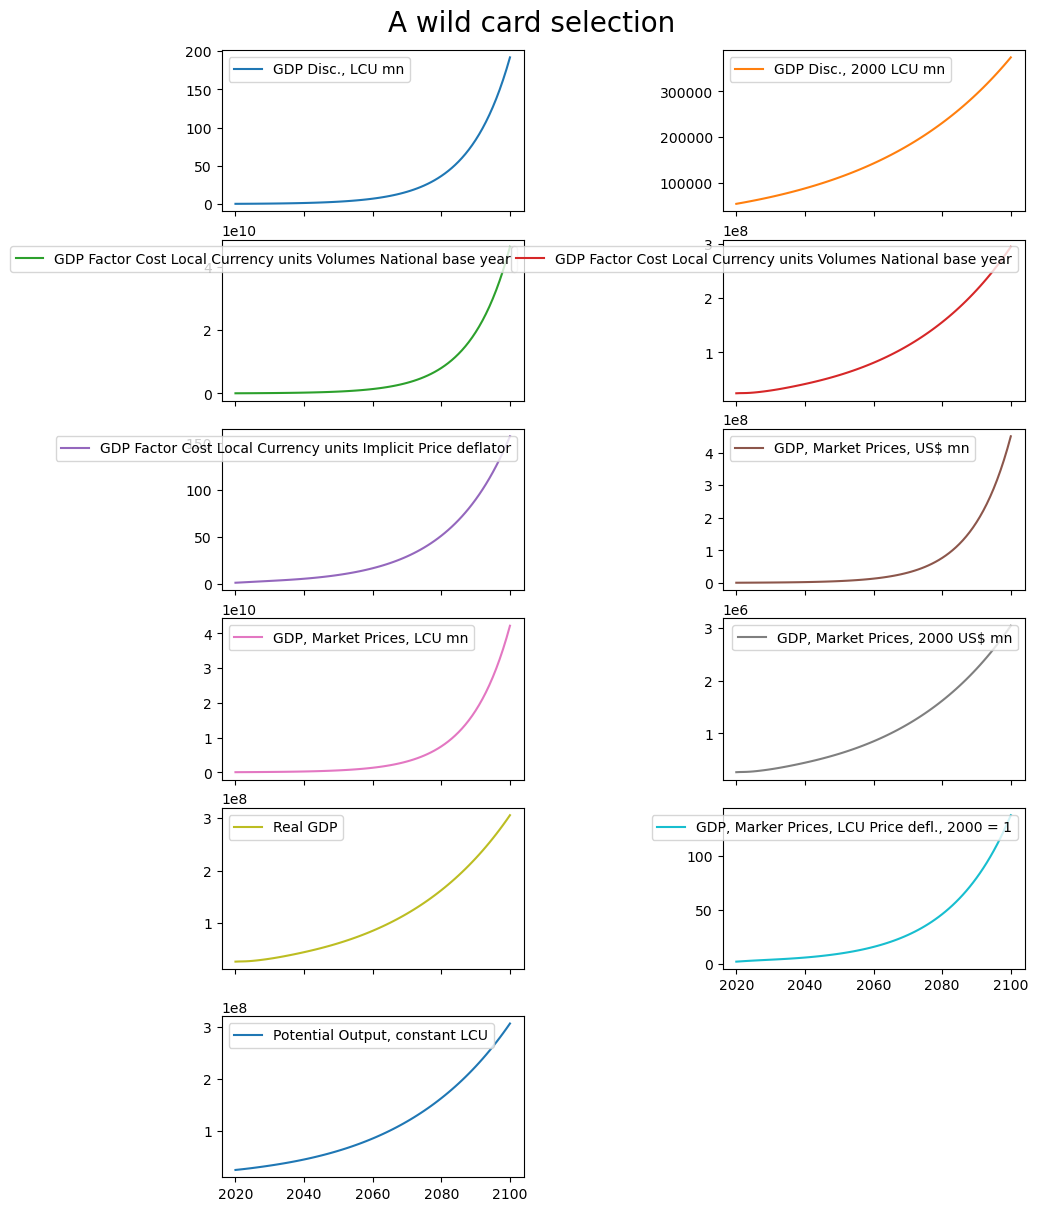

In [36]:
mpak.smpl(2020,2100);

mpak['PAKNYGDP??????'].rename().plot(title="A wild card selection");

### Options to plot() 

Common:<br>
- title (optional): title. Defaults to ''.
- colrow (TYPE, optional): Columns per row . Defaults to 2.
- sharey (TYPE, optional): Share y axis between plots. Defaults to False.
        
        
More excotic:<br>         
- splitchar (TYPE, optional): If the name should be split . Defaults to '__'.
- savefig (TYPE, optional): Save figure. Defaults to ''.
- xsize  (TYPE, optional): x size default to 10 
- ysize  (TYPE, optional): y size per row, defaults to 2
- ppos (optional): # of position to use if split. Defaults to -1.
- kind (TYPE, optional): Matplotlib kind . Defaults to 'line'.


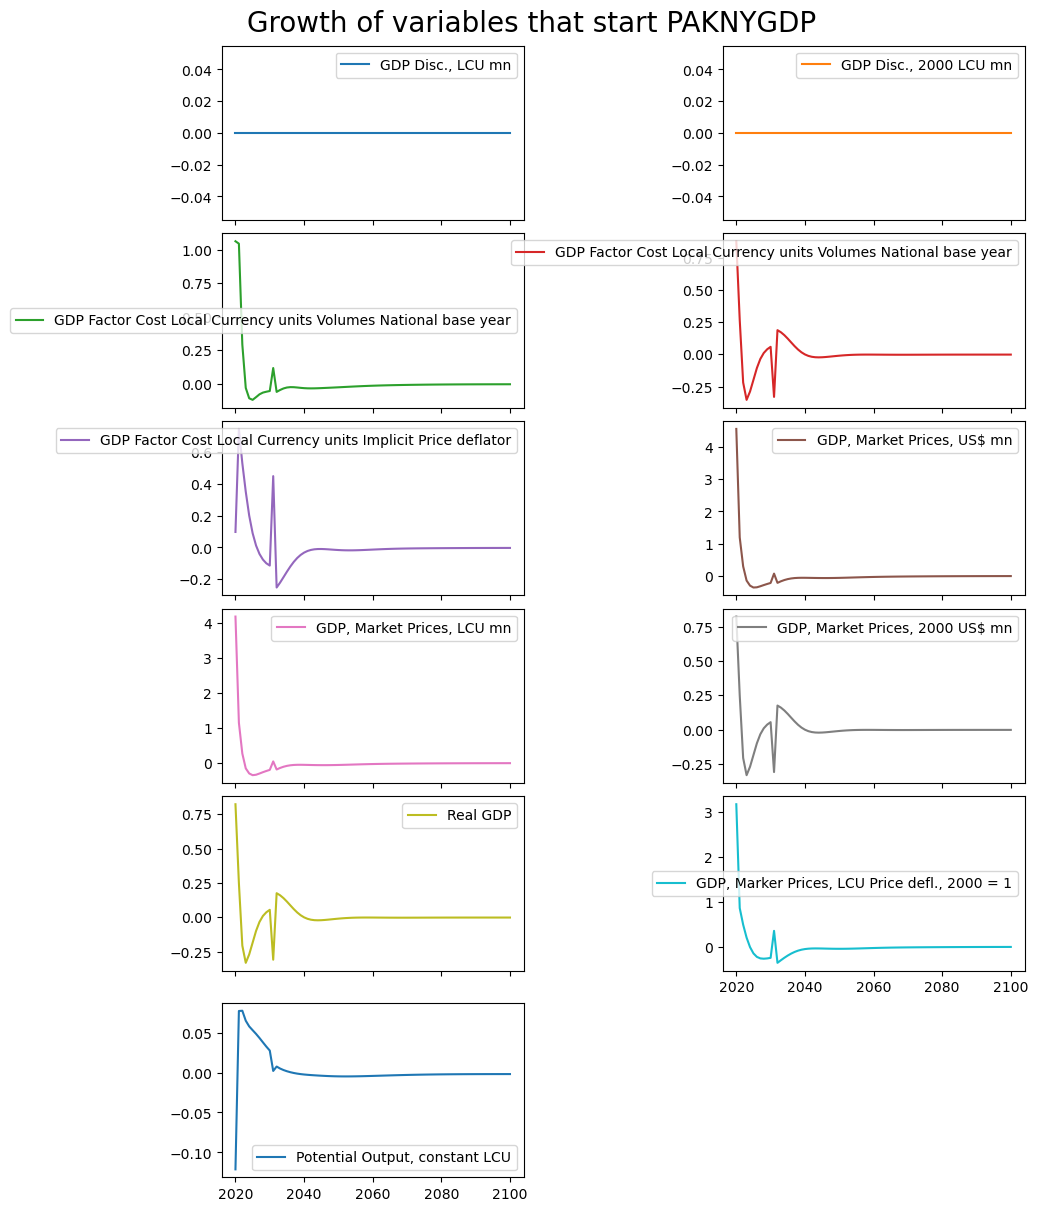

In [37]:
mpak['PAKNYGDP??????'].difpct.mul100.rename().plot(title='Growth of variables that start PAKNYGDP');

## Plotting inspiration


The following graph shows the components of GDP using the values of the baseline dataframe. 

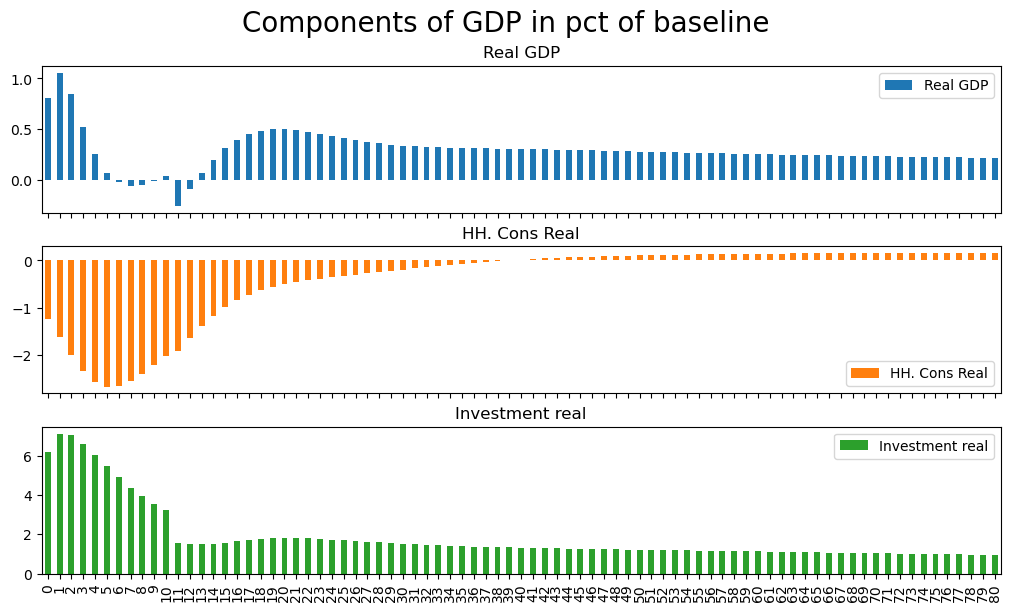

In [38]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNEGDIFTOTKN'].\
difpctlevel.mul100.rename().\
plot(title='Components of GDP in pct of baseline',colrow=1,kind='bar') ;

###  Heatmaps

For some model types heatmaps can be helpful, and they come out of the box. This feature was developed for use by bank stress test models. 

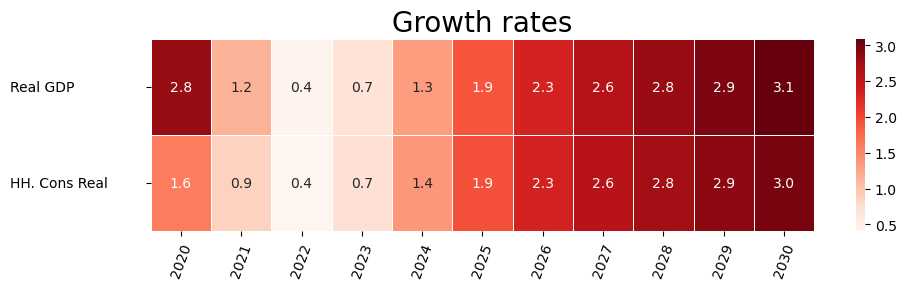

In [39]:
with mpak.set_smpl(2020,2030):
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.rename().mul100.heat(title='Growth rates',annot=True,dec=1,size=(10,3))  


<a id=’With’></a>
### Violin and boxplots, 
Not obvious for macro models, but useful for stress test  models with many banks. 

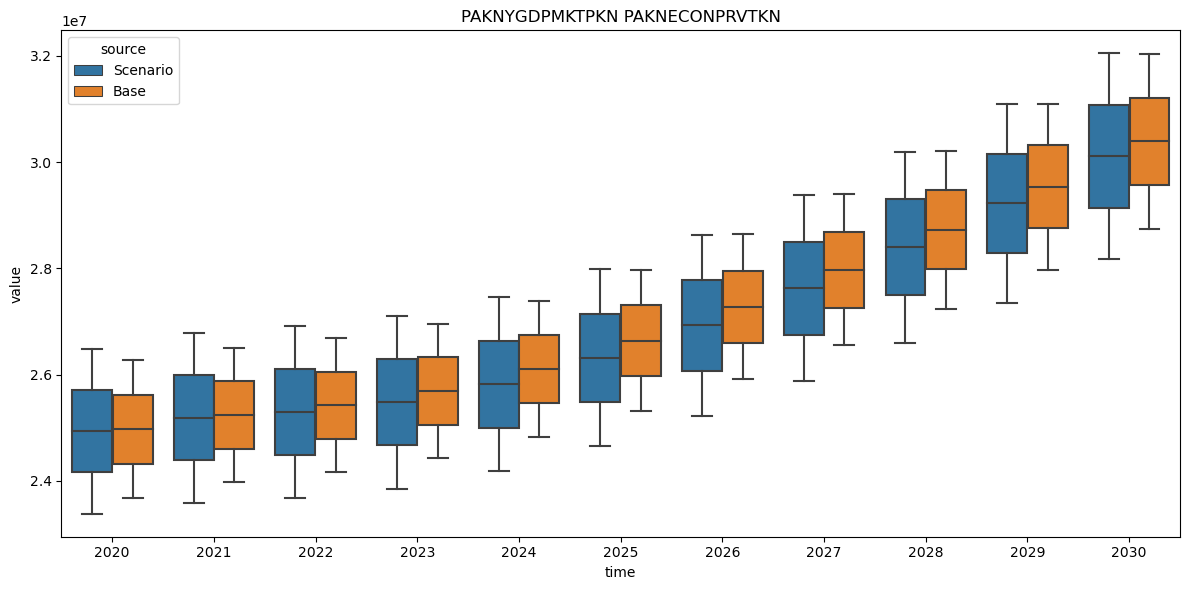

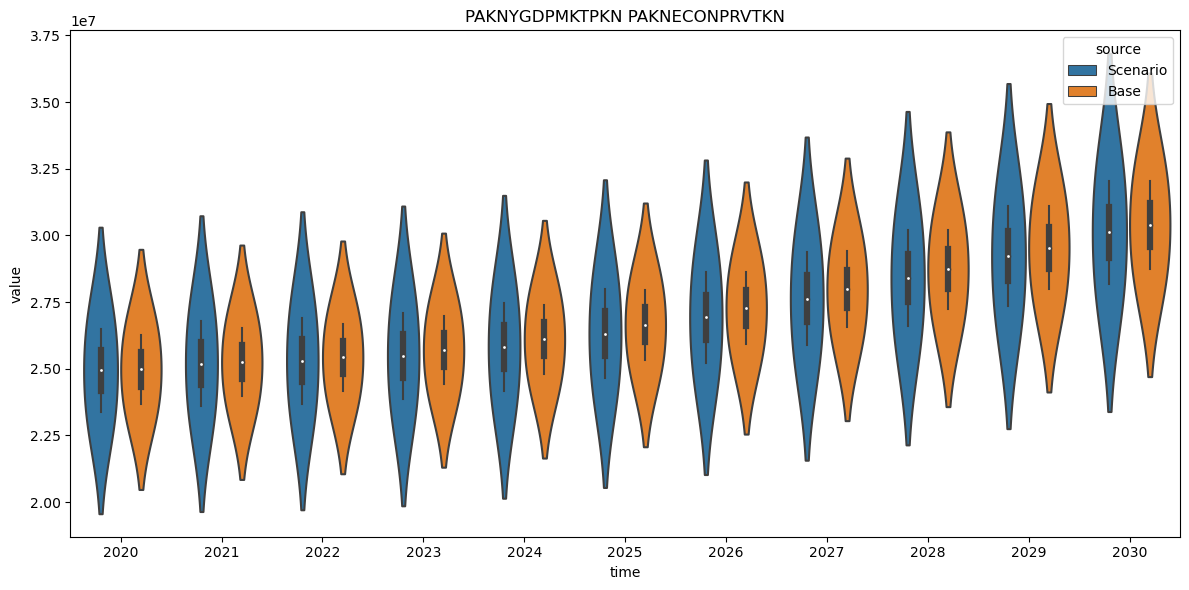

In [40]:
with mpak.set_smpl(2020,2030): 
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.box()  
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.violin()  


### Plot baseline vs alternative
A raw routine, only showing levels.
To make it really useful it should be expanded. 

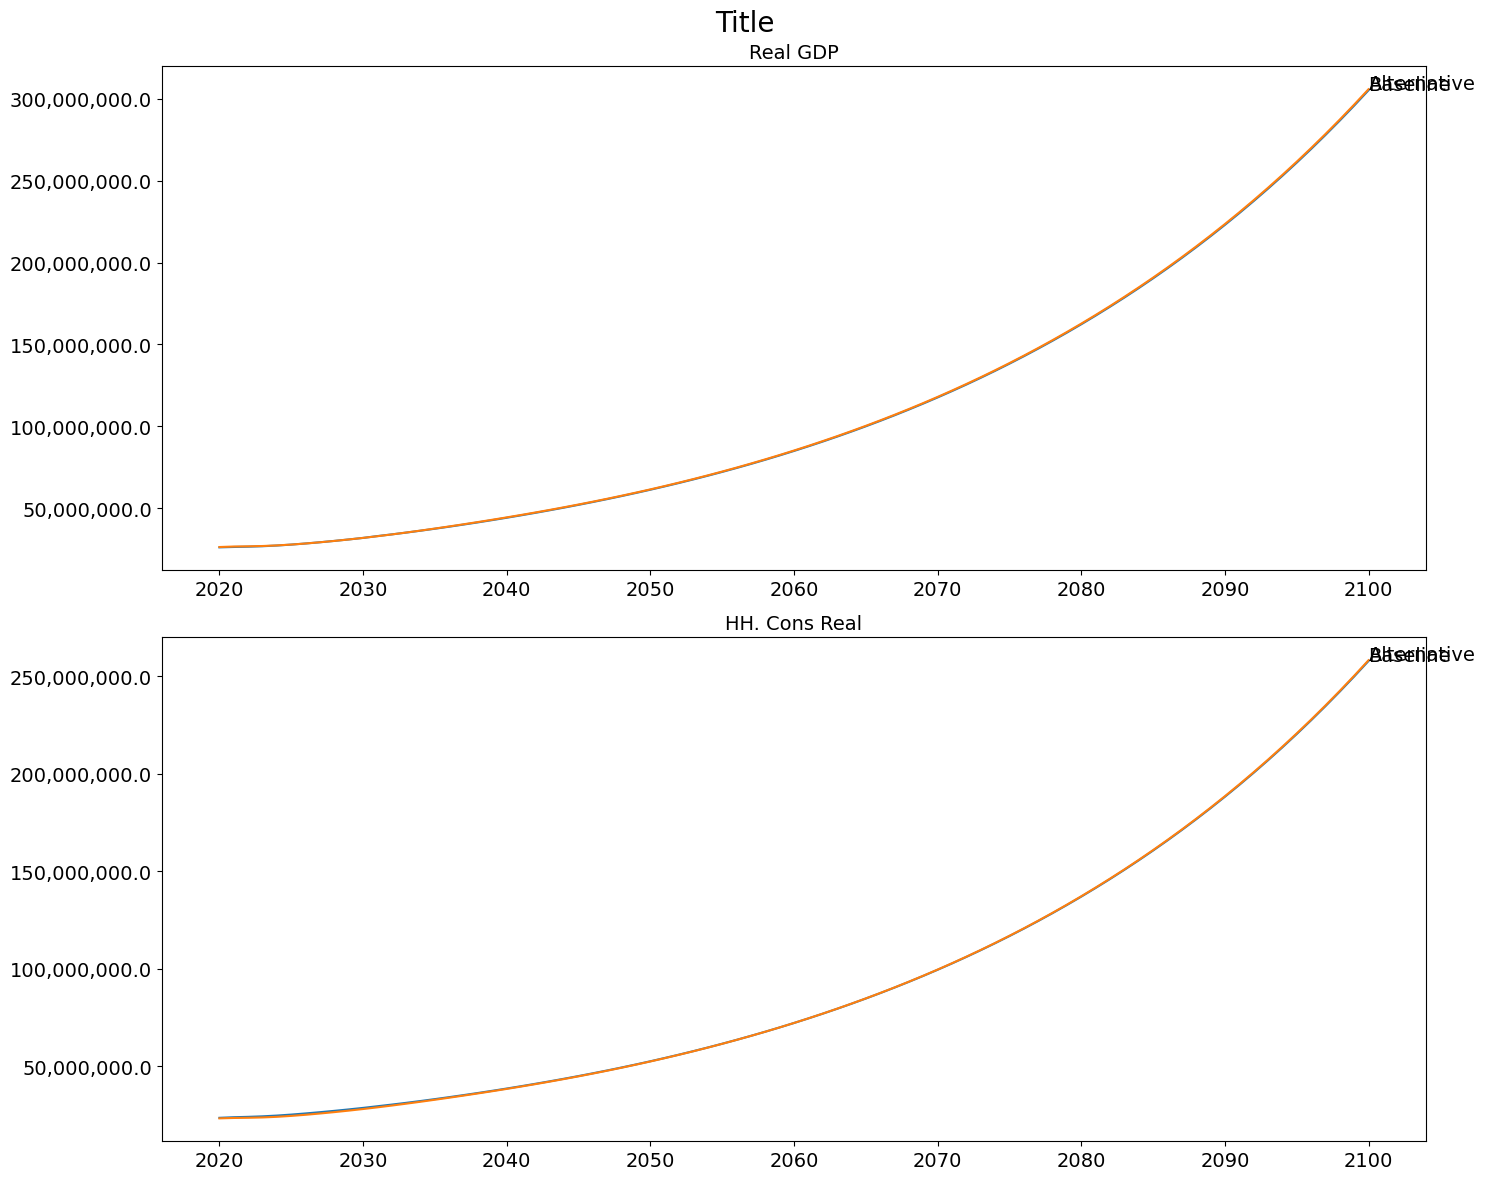

In [41]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].plot_alt() ;


## .draw() Graphical presentation of relationships between variables

.draw() helps you understand the relationship between variables in your model better. 
 
The thickness the arrow reflect the attribution of the the upstream variable to the impact on the downstream variable. 

### .draw(up = level, down = level)


You can specify how many levels up and down you want in your graphical presentation (Needs more explanation).

In this example all variables that depend directly upon GDP and consumption as well as those that are determined by them, are displayed. This means one step upstream in the model logic and one step downstream. 

More on the how to visualize the logic structure [here](../06_ModelAnalytics/ModelStructure.ipynb) 

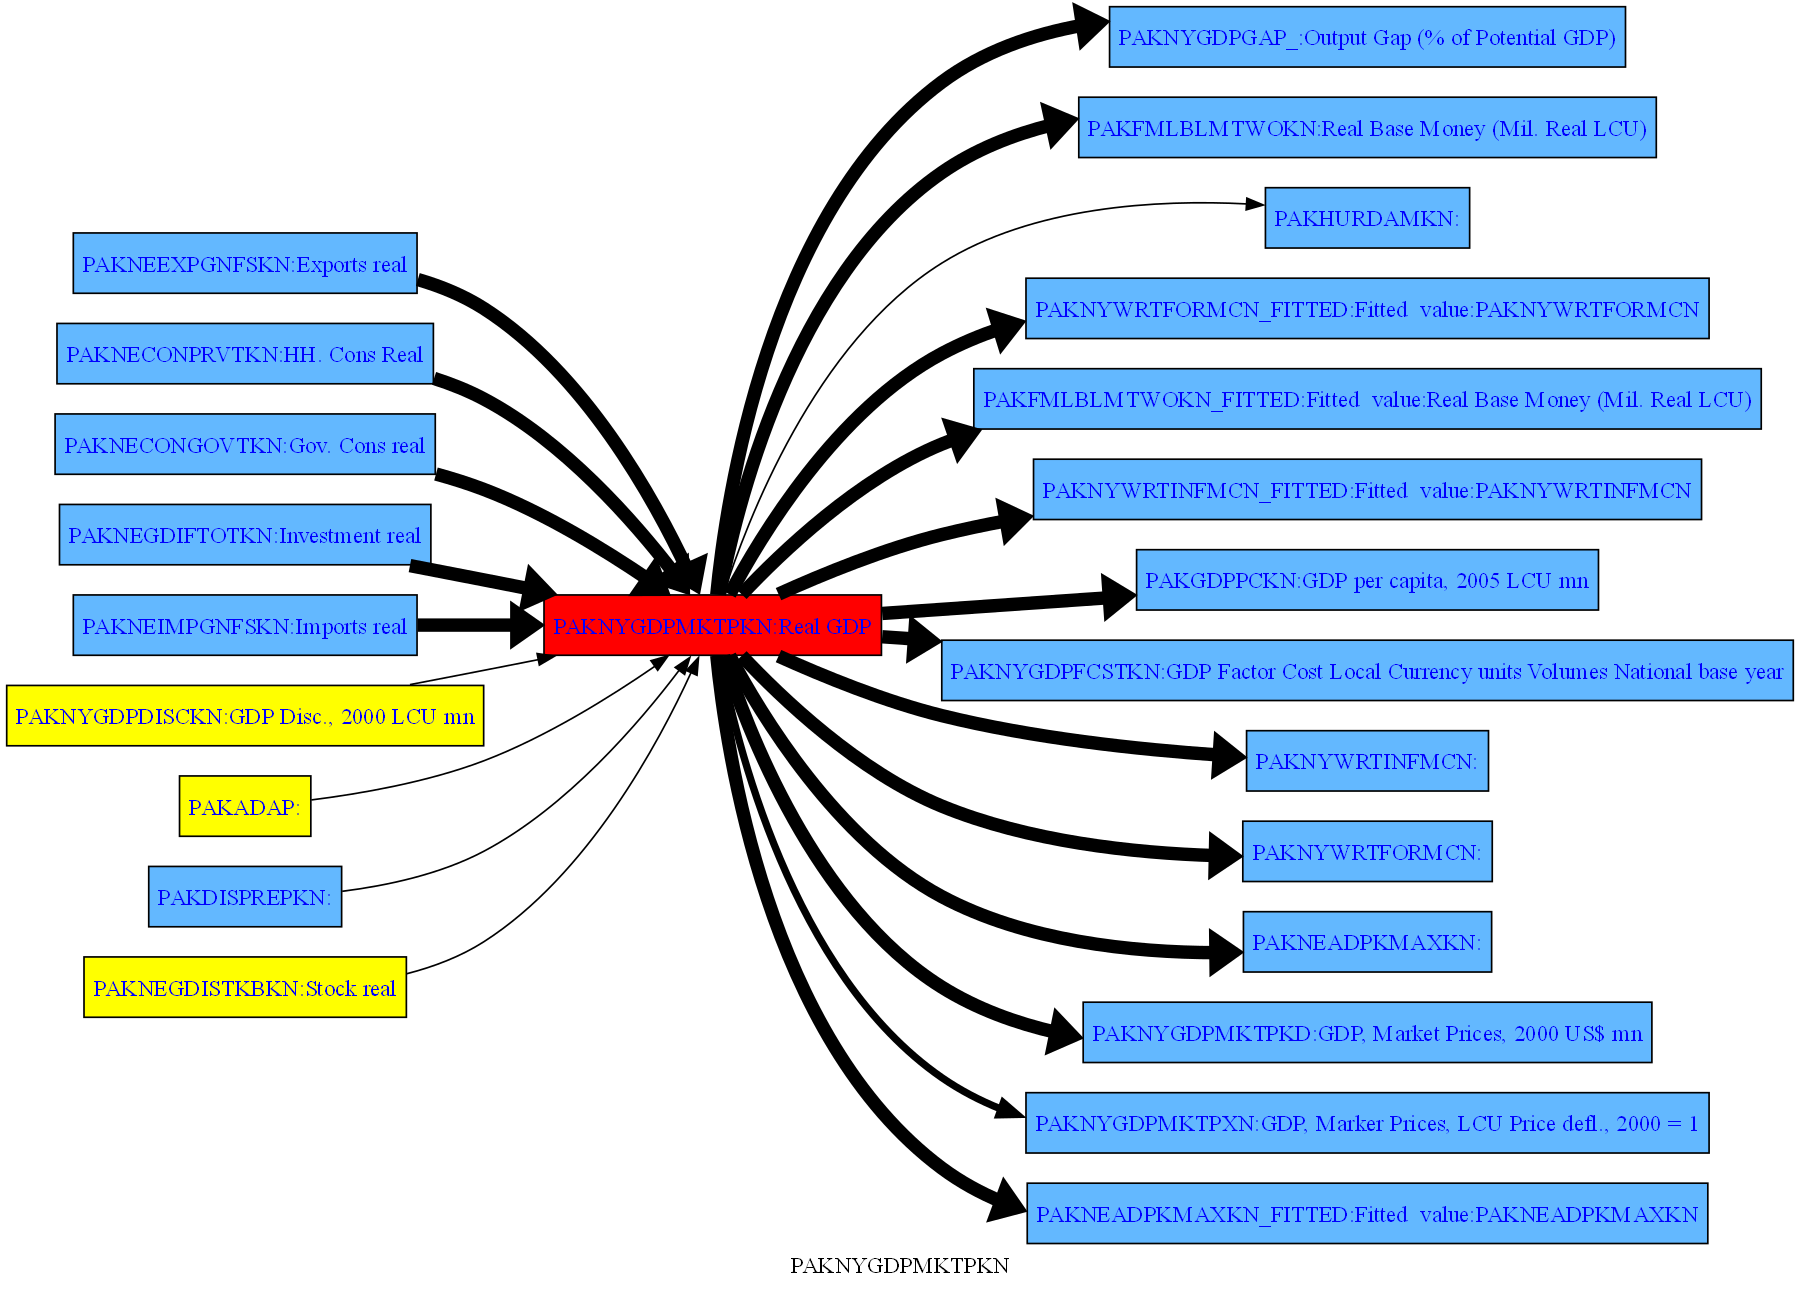

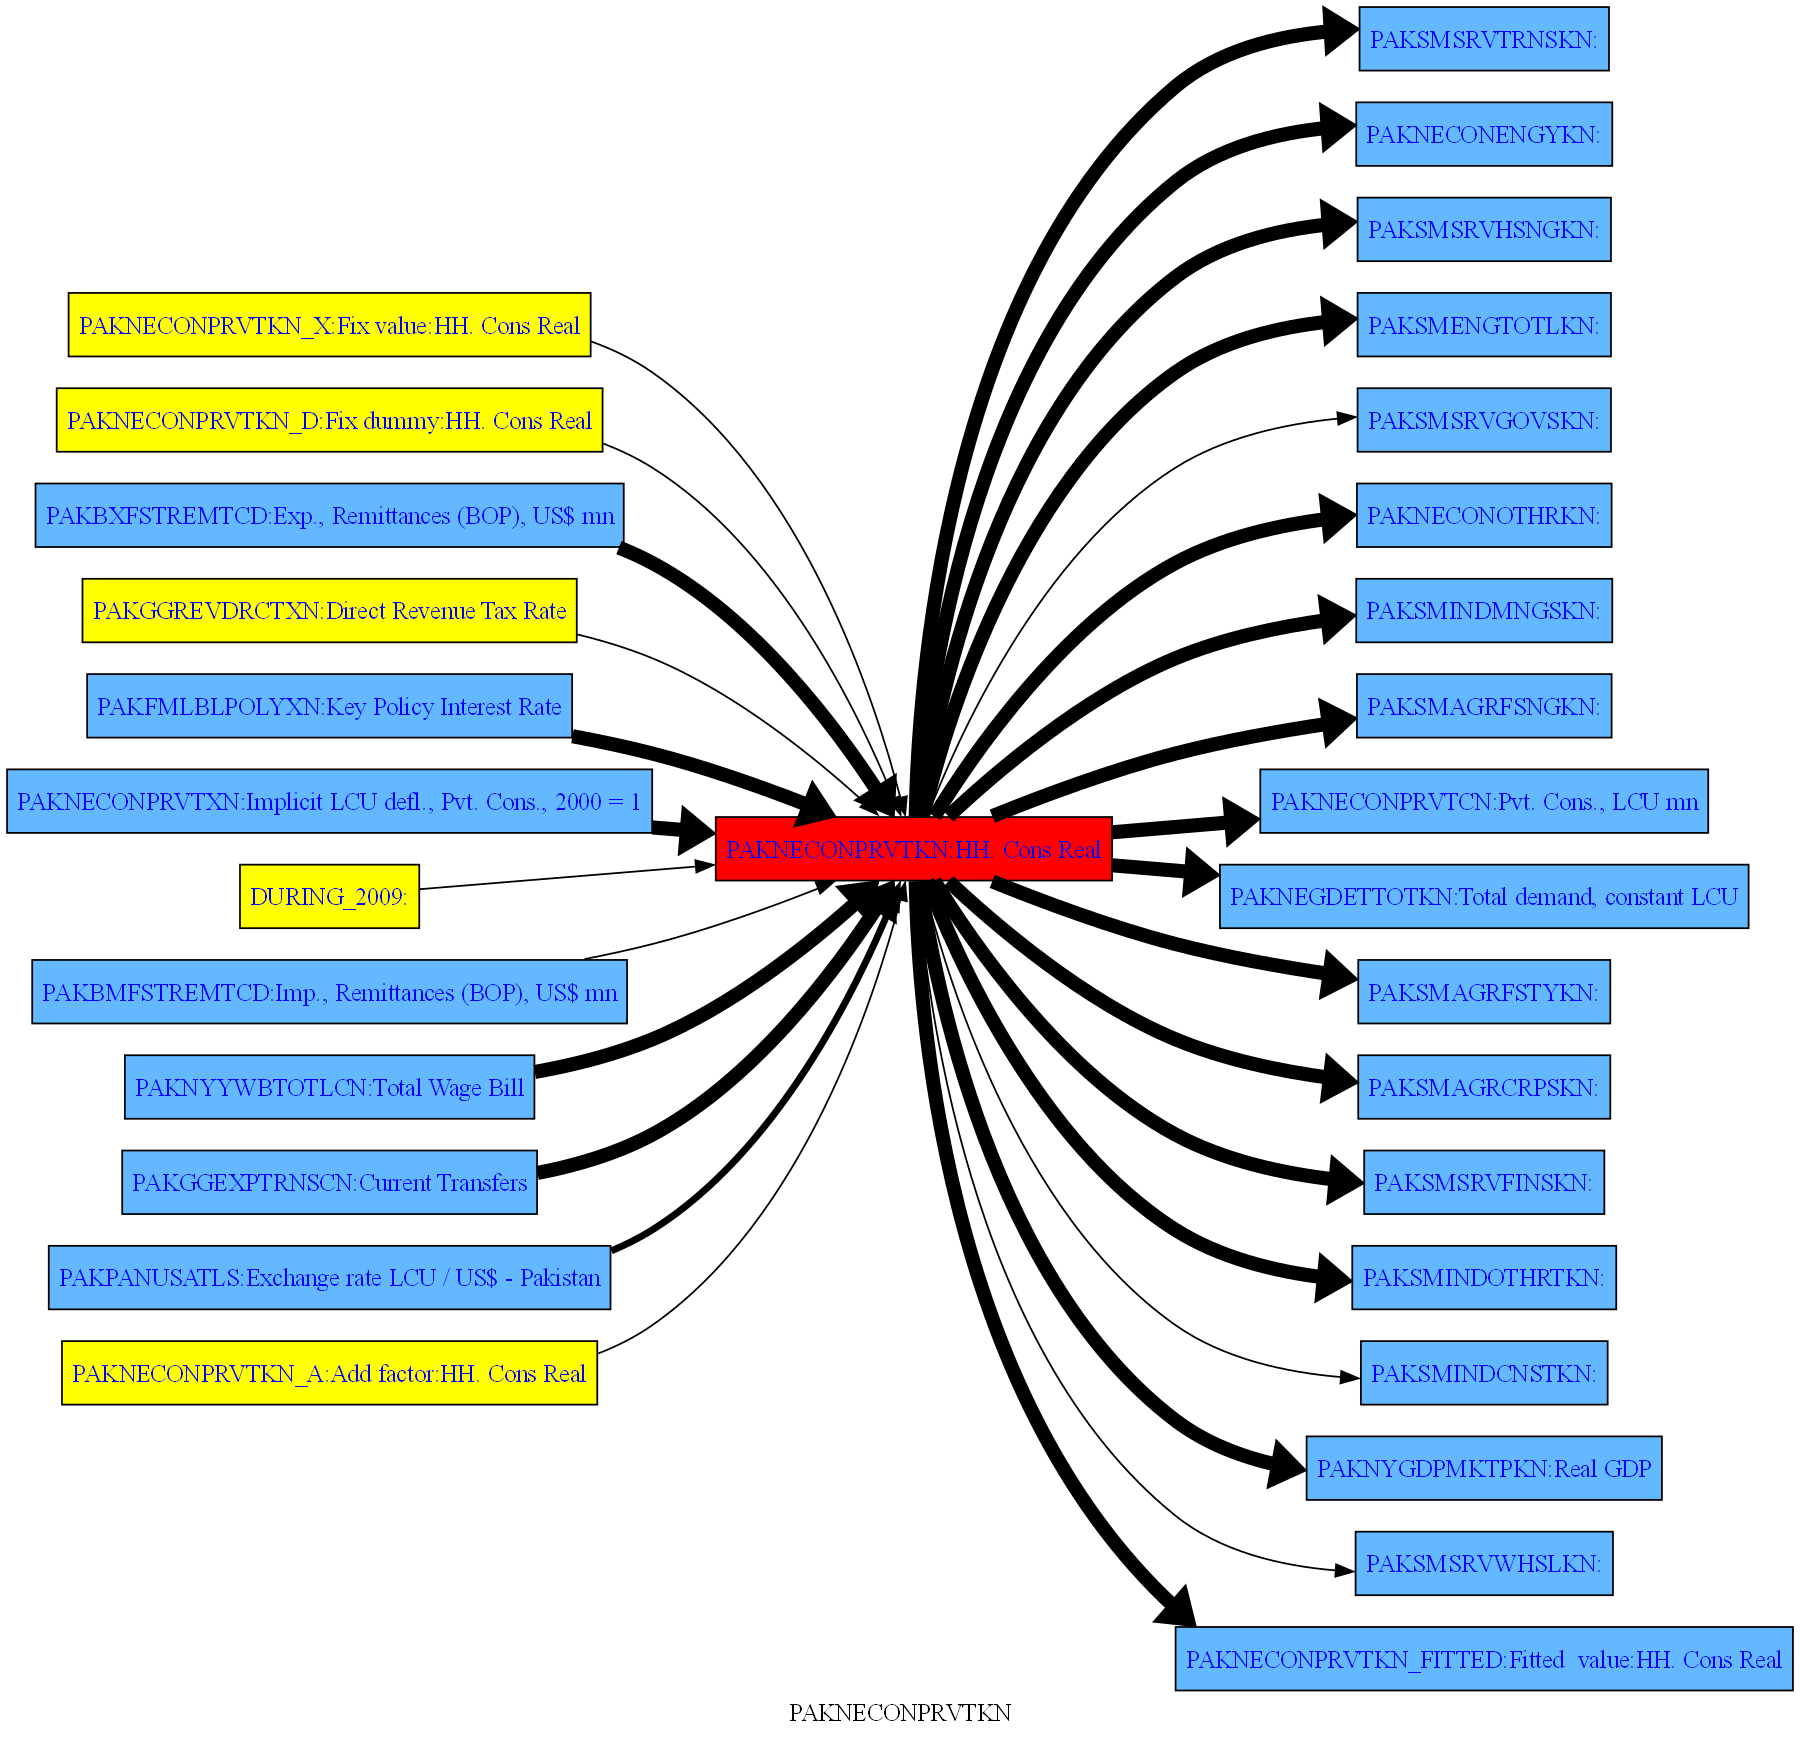

In [42]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1,png=latex)  # diagram of all direct dependencies 

### .draw(filter =\<minimal impact>)

By specifying filter=  only links where the minimal impact is more than \<minimal impact> are show. In this case 20% 


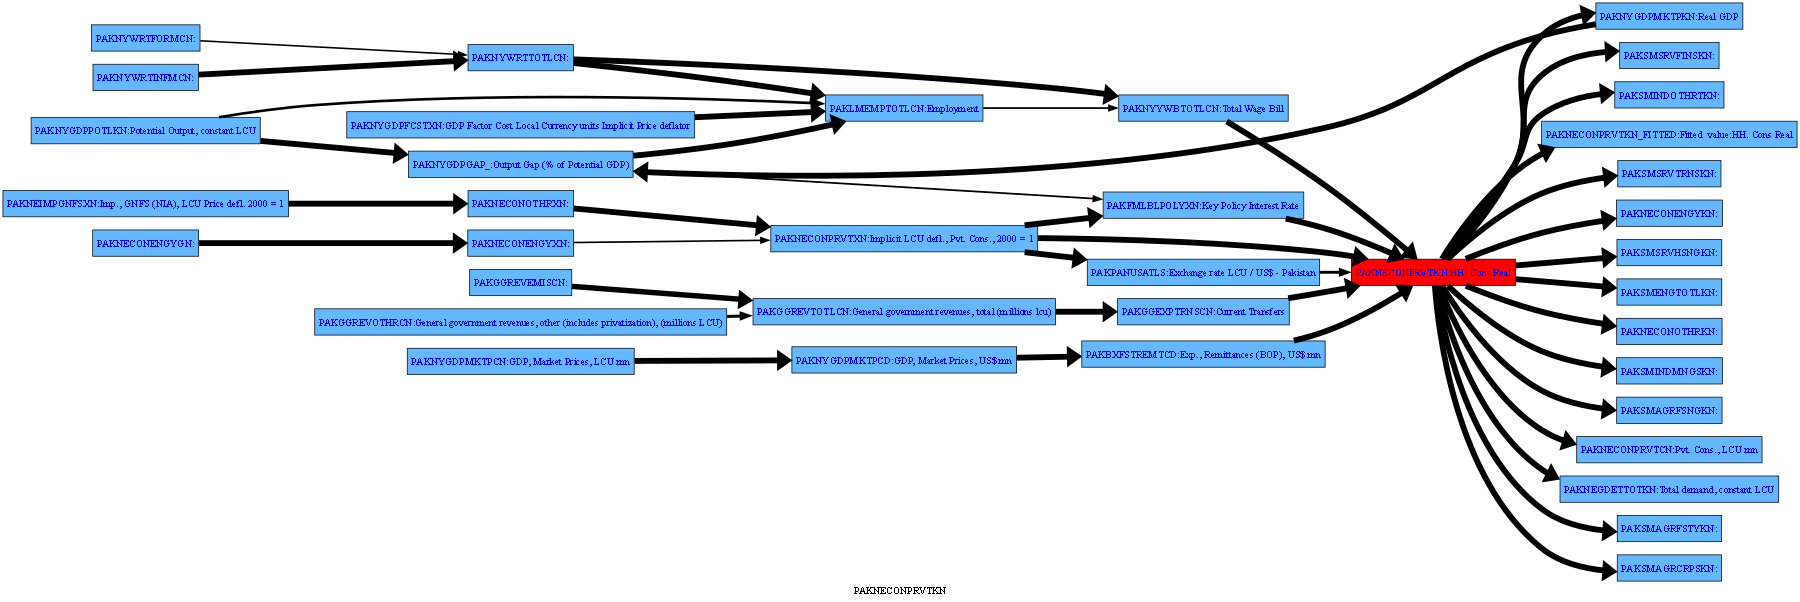

In [43]:
mpak['PAKNECONPRVTKN'].draw(up=3,down=1,filter=20,png=latex)  



## dekomp() Attribution of right hand side variables to
change in result. 
For more information on attribution look [here](../06_ModelAnalytics/AttributionSomeFeatures.ipynb)

The dekomp command decomposes the contributions of the right hand side variables to the observed change in the left hand side variables. 

In [44]:
with mpak.set_smpl(2021,2025):
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dekomp()  # frml attribution 


Formula        : FRML <IDENT> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $ 

                       2021        2022        2023        2024        2025
Variable    lag                                                            
Base        0   26511370.42 26685141.88 26963077.58 27393200.42 27963231.62
Alternative 0   26791399.34 26911678.24 27102694.02 27461697.71 27982312.97
Difference  0     280028.92   226536.35   139616.44    68497.30    19081.35
Percent     0          1.06        0.85        0.52        0.25        0.07

 Contributions to differende for  PAKNYGDPMKTPKN
                         2021       2022       2023       2024       2025
Variable       lag                                                       
PAKNECONPRVTKN 0   -385108.24 -480338.17 -571986.85 -637287.48 -673835.84
PAKNECONGOVTKN 0    348838.86  308073.15  266583.78  241492.43  228134.87
PAKNEGDIFTOTKN 0    

## Bespoken plots using matplotlib  (or plotly -later) (should go to a separate plot book 

The predefined plots are not necessary created for presentation purpose. To create  bespoken plots the they can be 
constructed directly in python scripts. The two main libraries are matplotlib, plotly but any ther python plotting library can be used. Here is an example using matplotlib. 

## Plot four separate plots of multiple series in grid   

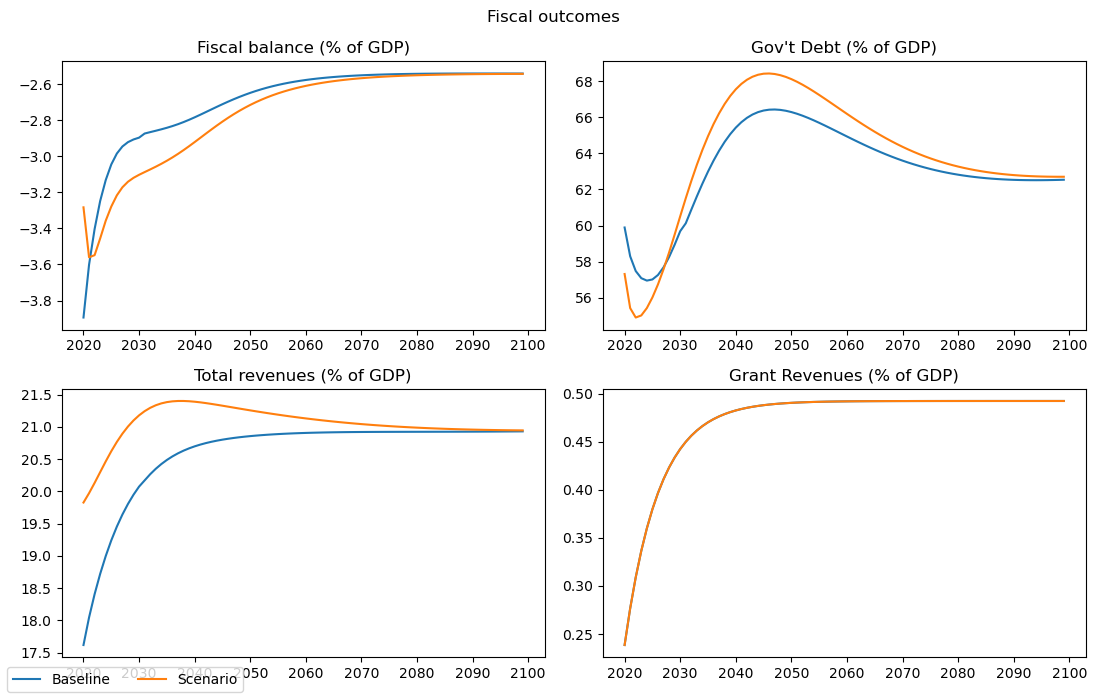

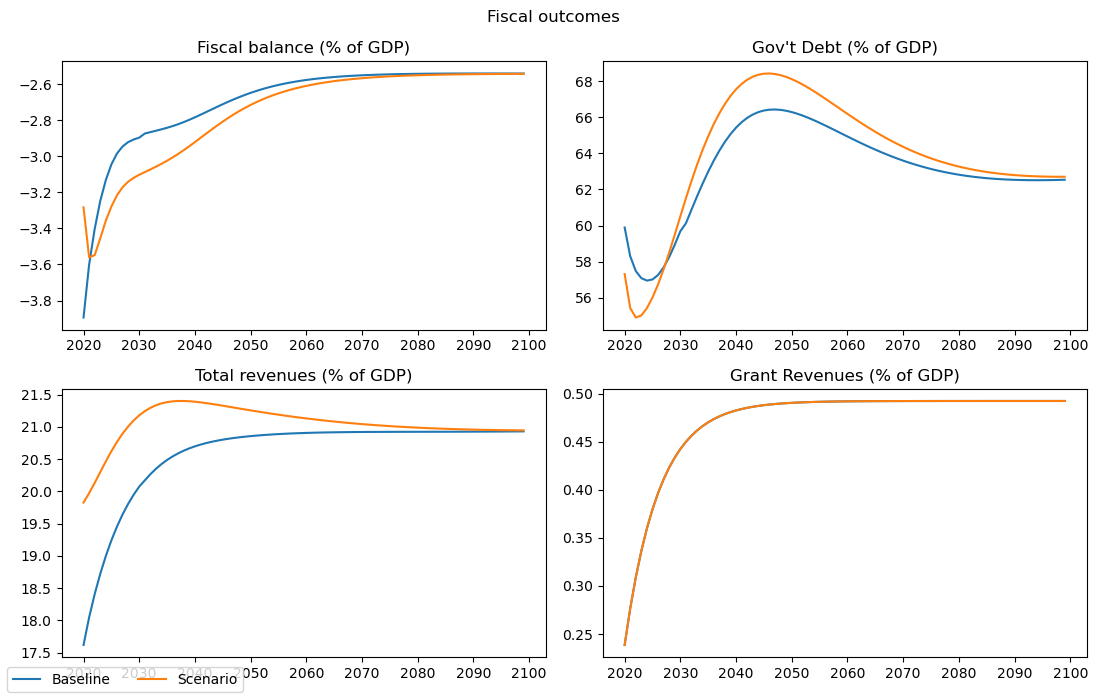

In [45]:
figure,axs= plt.subplots(2,2,figsize=(11, 7))
axs[0,0].plot(mpak.basedf.loc[2020:2099,'PAKGGBALOVRLCN_'],label='Baseline')
axs[0,0].plot(mpak.lastdf.loc[2020:2099,'PAKGGBALOVRLCN_'],label='Scenario')
#axs[0,0].legend()

axs[0,1].plot(mpak.basedf.loc[2020:2099,'PAKGGDBTTOTLCN_'],label='Baseline')
axs[0,1].plot(mpak.lastdf.loc[2020:2099,'PAKGGDBTTOTLCN_'],label='Scenario')

axs[1,0].plot(mpak.basedf.loc[2020:2099,'PAKGGREVTOTLCN']/mpak.basedf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
axs[1,0].plot(mpak.lastdf.loc[2020:2099,'PAKGGREVTOTLCN']/mpak.lastdf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')

axs[1,1].plot(mpak.basedf.loc[2020:2099,'PAKGGREVGRNTCN']/mpak.basedf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
axs[1,1].plot(mpak.lastdf.loc[2020:2099,'PAKGGREVGRNTCN']/mpak.lastdf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')
#axs2[4].plot(mpak.lastdf.loc[2000:2099,'PAKGGREVGRNTCN']/mpak.basedf.loc[2000:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')

axs[0,0].title.set_text("Fiscal balance (% of GDP)")
axs[0,1].title.set_text("Gov't Debt (% of GDP)")
axs[1,0].title.set_text("Total revenues (% of GDP)")
axs[1,1].title.set_text("Grant Revenues (% of GDP)")
figure.suptitle("Fiscal outcomes")

plt.figlegend(['Baseline','Scenario'],loc='lower left',ncol=5)  
figure.tight_layout(pad=2.3) #Ensures legend does not overlap dates
figure